In [ ]:
# import libraries
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import matplotlib.pyplot as plt


# load data
train_df = pd.read_pickle("../data/train.pickle")
val_df   = pd.read_pickle("../data/val.pickle")

train_texts = train_df["text"].astype(str).tolist()
val_texts   = val_df["text"].astype(str).tolist()

In [4]:

def add_history_features(
    df,
    global_v_mean,
    global_a_mean,
):
    # sort by timestamp
    df = df.sort_values(["user_id", "timestamp", "text_id"]).reset_index(drop=True)

    # only use previous labels
    v_prev = df.groupby("user_id")["valence"].shift(1)
    a_prev = df.groupby("user_id")["arousal"].shift(1)

    # pre / last
    df["v_pre"] = v_prev.fillna(global_v_mean)
    df["a_pre"] = a_prev.fillna(global_a_mean)

    # mean so far
    df["v_mean_sofar"] = (
        v_prev.groupby(df["user_id"])
              .expanding()
              .mean()
              .reset_index(level=0, drop=True)
              .fillna(global_v_mean)
    )
    df["a_mean_sofar"] = (
        a_prev.groupby(df["user_id"])
              .expanding()
              .mean()
              .reset_index(level=0, drop=True)
              .fillna(global_a_mean)
    )

    # std so far
    df["v_std_sofar"] = (
        v_prev.groupby(df["user_id"])
              .expanding()
              .std()
              .reset_index(level=0, drop=True)
              .fillna(0.0)
    )
    df["a_std_sofar"] = (
        a_prev.groupby(df["user_id"])
              .expanding()
              .std()
              .reset_index(level=0, drop=True)
              .fillna(0.0)
    )

    # min so far
    df["v_min_sofar"] = (
        v_prev.groupby(df["user_id"])
              .cummin()
              .fillna(global_v_mean)
    )
    df["a_min_sofar"] = (
        a_prev.groupby(df["user_id"])
              .cummin()
              .fillna(global_a_mean)
    )

    # max so far
    df["v_max_sofar"] = (
        v_prev.groupby(df["user_id"])
              .cummax()
              .fillna(global_v_mean)
    )
    df["a_max_sofar"] = (
        a_prev.groupby(df["user_id"])
              .cummax()
              .fillna(global_a_mean)
    )
    
    # pre-residuals
    df["v_pre_res"] = (v_prev - df["v_mean_sofar"]).fillna(0.0)
    df["a_pre_res"] = (a_prev - df["a_mean_sofar"]).fillna(0.0)


    return df


In [5]:
def add_cos_prev_stable(df, emb):
    df = df.copy()

    pos = df.groupby("user_id").cumcount().values

    prev_global_idx = pd.Series(np.arange(len(df))).groupby(df["user_id"]).shift(1)

    cos_prev = np.zeros(len(df), dtype=np.float32)
    valid = pos > 0

    prv_idx = prev_global_idx[valid].astype(int).values
    cur = emb[valid]
    prv = emb[prv_idx]

    cur_norm = np.linalg.norm(cur, axis=1) + 1e-9
    prv_norm = np.linalg.norm(prv, axis=1) + 1e-9
    cos_prev[valid] = (cur * prv).sum(axis=1) / (cur_norm * prv_norm)

    df["cos_prev"] = cos_prev
    return df


In [6]:

def add_extreme_anchor_cos_sofar(df, emb):
    """
    Add:
      cos_to_vmax_sofar, cos_to_vmin_sofar, cos_to_amax_sofar, cos_to_amin_sofar

    df must be sorted by [user_id, timestamp, text_id] and reset_index(drop=True).
    emb must align with df rows, shape (N, D).
    """
    n = len(df)
    cos_to_vmax = np.zeros(n, dtype=np.float32)
    cos_to_vmin = np.zeros(n, dtype=np.float32)
    cos_to_amax = np.zeros(n, dtype=np.float32)
    cos_to_amin = np.zeros(n, dtype=np.float32)

    norms = np.linalg.norm(emb, axis=1) + 1e-9

    users = df["user_id"].values
    v = df["valence"].values
    a = df["arousal"].values

    last_user = None
    vmax_idx = vmin_idx = amax_idx = amin_idx = None
    vmax_val = -np.inf
    vmin_val = np.inf
    amax_val = -np.inf
    amin_val = np.inf

    for i in range(n):
        uid = users[i]
        if uid != last_user:
            last_user = uid
            vmax_idx = vmin_idx = amax_idx = amin_idx = None
            vmax_val = -np.inf
            vmin_val = np.inf
            amax_val = -np.inf
            amin_val = np.inf

        # compute cosine to anchors from PAST only
        if vmax_idx is not None:
            cos_to_vmax[i] = float(np.dot(emb[i], emb[vmax_idx]) / (norms[i] * norms[vmax_idx]))
        if vmin_idx is not None:
            cos_to_vmin[i] = float(np.dot(emb[i], emb[vmin_idx]) / (norms[i] * norms[vmin_idx]))
        if amax_idx is not None:
            cos_to_amax[i] = float(np.dot(emb[i], emb[amax_idx]) / (norms[i] * norms[amax_idx]))
        if amin_idx is not None:
            cos_to_amin[i] = float(np.dot(emb[i], emb[amin_idx]) / (norms[i] * norms[amin_idx]))

        # update anchors using CURRENT row label for future rows
        if v[i] > vmax_val:
            vmax_val = v[i]
            vmax_idx = i
        if v[i] < vmin_val:
            vmin_val = v[i]
            vmin_idx = i
        if a[i] > amax_val:
            amax_val = a[i]
            amax_idx = i
        if a[i] < amin_val:
            amin_val = a[i]
            amin_idx = i

    df = df.copy()
    df["cos_to_vmax_sofar"] = cos_to_vmax
    df["cos_to_vmin_sofar"] = cos_to_vmin
    df["cos_to_amax_sofar"] = cos_to_amax
    df["cos_to_amin_sofar"] = cos_to_amin
    return df


In [10]:
# 1) sort
sort_cols = ["user_id", "timestamp", "text_id"]
train_df = train_df.sort_values(sort_cols).reset_index(drop=True)
val_df   = val_df.sort_values(sort_cols).reset_index(drop=True)

# 2) compute history extremes (needed for v_max_sofar/v_min_sofar/a_max_sofar/a_min_sofar)
global_v_mean = float(train_df["valence"].mean())
global_a_mean = float(train_df["arousal"].mean())

train_df = add_history_features(train_df, global_v_mean, global_a_mean)
val_df   = add_history_features(val_df,   global_v_mean, global_a_mean)

# 3) embeddings ONLY for cosine features (embeddings will NOT be used as model inputs)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
encoder = SentenceTransformer("all-MiniLM-L6-v2", device=DEVICE)

train_texts = train_df["text"].astype(str).tolist()
val_texts   = val_df["text"].astype(str).tolist()

X_train_emb = encoder.encode(train_texts, batch_size=64, show_progress_bar=True, convert_to_numpy=True)
X_val_emb   = encoder.encode(val_texts,   batch_size=64, show_progress_bar=True, convert_to_numpy=True)

# 4) add the 4 cos_sofar features
train_df = add_extreme_anchor_cos_sofar(train_df, X_train_emb)
val_df   = add_extreme_anchor_cos_sofar(val_df,   X_val_emb)

# 5) ONLY use 4 cos_sofar + their corresponding V/A extreme values
feat_cols = [
    "cos_to_vmax_sofar", "v_max_sofar",
    "cos_to_vmin_sofar", "v_min_sofar",
    "cos_to_amax_sofar", "a_max_sofar",
    "cos_to_amin_sofar", "a_min_sofar",
]

X_train = train_df[feat_cols].astype(float).values
X_val   = val_df[feat_cols].astype(float).values

y_train = train_df[["valence","arousal"]].astype(float).values
y_val   = val_df[["valence","arousal"]].astype(float).values

print("X_train:", X_train.shape, "X_val:", X_val.shape)

# 6) train + evaluate
reg = MultiOutputRegressor(Ridge(alpha=1.0, random_state=42))
reg.fit(X_train, y_train)
pred = reg.predict(X_val)

rmse_v = np.sqrt(mean_squared_error(y_val[:, 0], pred[:, 0]))
rmse_a = np.sqrt(mean_squared_error(y_val[:, 1], pred[:, 1]))
mae_v  = mean_absolute_error(y_val[:, 0], pred[:, 0])
mae_a  = mean_absolute_error(y_val[:, 1], pred[:, 1])

print("\n==== Validation Metrics (4 cos_sofar + extreme V/A only + Ridge) ====")
print(f"Valence  RMSE: {rmse_v:.4f} | MAE: {mae_v:.4f}")
print(f"Arousal  RMSE: {rmse_a:.4f} | MAE: {mae_a:.4f}")
print(f"Avg RMSE: {(rmse_v + rmse_a)/2:.4f}")

Batches:   0%|          | 0/34 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

X_train: (2165, 8) X_val: (599, 8)

==== Validation Metrics (4 cos_sofar + extreme V/A only + Ridge) ====
Valence  RMSE: 1.2975 | MAE: 1.0550
Arousal  RMSE: 0.6848 | MAE: 0.5916
Avg RMSE: 0.9912


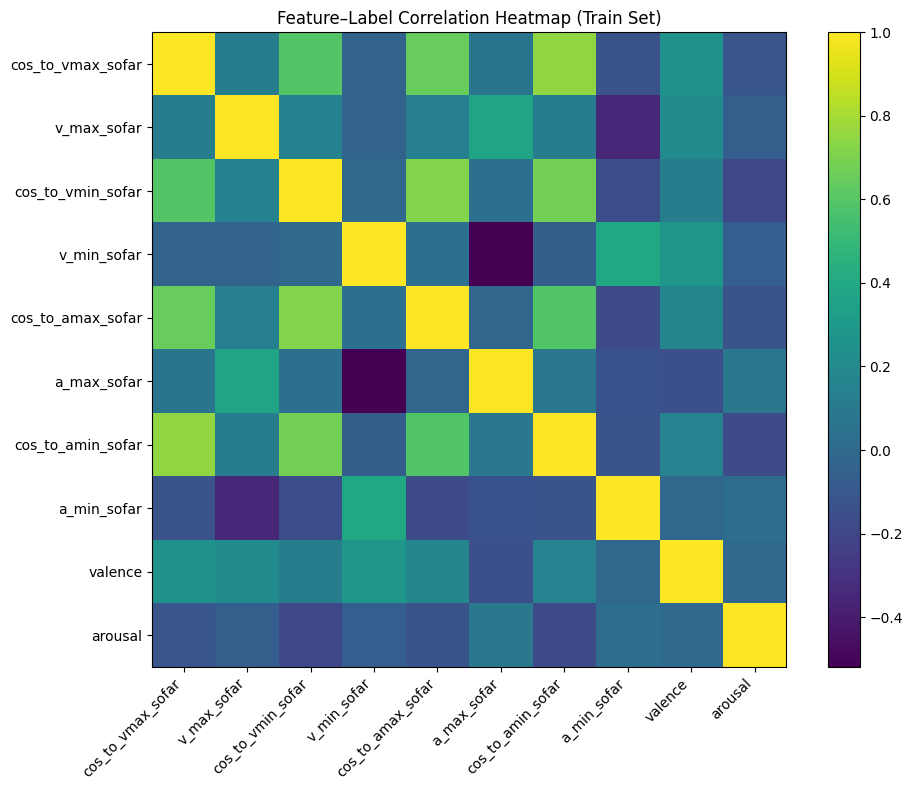

In [11]:
feat_cols = [
    "cos_to_vmax_sofar", "v_max_sofar",
    "cos_to_vmin_sofar", "v_min_sofar",
    "cos_to_amax_sofar", "a_max_sofar",
    "cos_to_amin_sofar", "a_min_sofar",
]

label_cols = ["valence", "arousal"]

df_corr = train_df[feat_cols + label_cols].astype(float)
corr = df_corr.corr()

plt.figure(figsize=(10, 8))
plt.imshow(corr)
plt.colorbar()

plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)

plt.title("Feature–Label Correlation Heatmap (Train Set)")
plt.tight_layout()
plt.show()


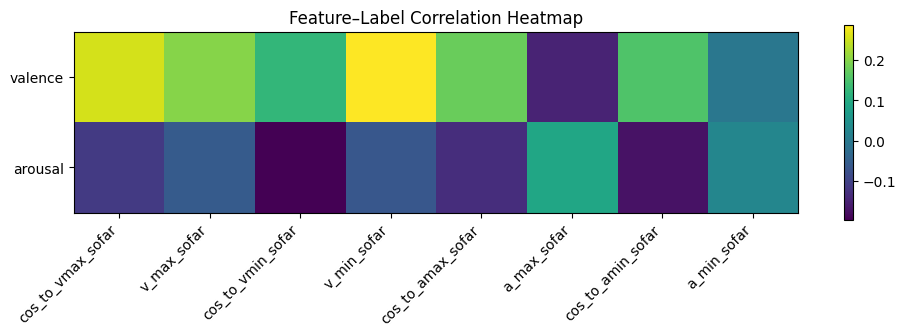

In [12]:
corr_fl = train_df[feat_cols].corrwith(train_df["valence"])
corr_fa = train_df[feat_cols].corrwith(train_df["arousal"])

corr_small = np.vstack([corr_fl.values, corr_fa.values])

plt.figure(figsize=(10, 3))
plt.imshow(corr_small)
plt.colorbar()

plt.xticks(range(len(feat_cols)), feat_cols, rotation=45, ha="right")
plt.yticks([0, 1], ["valence", "arousal"])

plt.title("Feature–Label Correlation Heatmap")
plt.tight_layout()
plt.show()
